#setup

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy import stats 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
import warnings 
warnings.filterwarnings('ignore')       


In [2]:
from google.colab import drive
drive.mount('/content/drive')  


Mounted at /content/drive


In [3]:
data= pd.read_csv('/content/drive/MyDrive/clean_for_modeling_data.csv')     

In [4]:
data

,kilometrage,age,marque,modele,carburant,boite,prix
0,145000.0,5,volkswagen,golf 7,Essence,Manuelle,58500.0
1,110000.0,4,toyota,yaris,Essence,Manuelle,35000.0
2,190000.0,8,isuzu,d-max,Diesel,Manuelle,57000.0
3,164000.0,13,citroen,c4,Essence,Manuelle,23500.0
4,80000.0,8,nissan,juke,Essence,Manuelle,46000.0
...,...,...,...,...,...,...,...
52415,155000.0,11,mini,cooper,Essence,Manuelle,33000.0
52416,68000.0,4,skoda,fabia,Essence,Manuelle,34800.0
52417,130000.0,14,hyundai,tucson,Diesel,Automatique,56000.0
52418,161000.0,11,bmw,serie 3,Essence,Automatique,44900.0


In [5]:
data.isnull().sum() 

kilometrage    0
age            0
marque         0
modele         0
carburant      0
boite          0
prix           0
dtype: int64

In [6]:
data.describe()

,kilometrage,age,prix
count,52420.000000,52420.000000,52420.000000
mean,170811.455876,10.177623,32749.866845
std,80521.718693,5.721696,22625.912171
min,5000.000000,0.000000,10000.000000
25%,110000.000000,6.000000,19000.000000
50%,167000.000000,9.000000,26500.000000
75%,220000.000000,14.000000,37500.000000
max,400000.000000,29.000000,200000.000000


In [7]:
#remove sequential digits where diff is 1 
data['prix'] = data['prix'].astype(str) 
def has_ascending_order_with_diff_one(num):
    num_str = str(num).replace('-', '')  # remove hyphen (-) characters
    return all(num_str[i] < num_str[i+1] for i in range(len(num_str)-1)) and all(int(num_str[i+1]) - int(num_str[i]) == 1 for i in range(len(num_str)-1))
 
data = data[~(data['prix'].apply(has_ascending_order_with_diff_one) & (data['prix'].str.len() >= 3))]

In [8]:
data.shape

(52420, 7)

In [9]:
data['marque'].value_counts()

volkswagen        9089
peugeot           6741
renault           6187
citroen           5316
fiat              3475
                  ... 
zotye                1
masey ferguson       1
pontiac              1
lamborghini          1
changhe              1
Name: marque, Length: 63, dtype: int64

In [10]:
data['marque'].unique()

array(['volkswagen', 'toyota', 'isuzu', 'citroen', 'nissan', 'fiat',
       'renault', 'peugeot', 'autres', 'seat', 'bmw', 'opel', 'kia',
       'ford', 'dacia', 'smart', 'iveco', 'mazda', 'audi', 'hyundai',
       'mercedes-benz', 'chevrolet', 'mitsubishi', 'ssangyong', 'jaguar',
       'suzuki', 'daewoo', 'mini', 'honda', 'lancia', 'land rover', 'ac',
       'skoda', 'jeep', 'mahindra', 'alfa romeo', 'cadillac', 'ufo',
       'chery', 'byd', 'porsche', 'infiniti', 'rover', 'acrea', 'gmc',
       'volvo', 'ferrari', 'man', 'zotye', 'chrysler', 'daihatsu',
       'aston martin', 'dodge', 'bentley', 'acura', 'geely', 'foton',
       'masey ferguson', 'hummer', 'pontiac', 'lincoln', 'lamborghini',
       'changhe'], dtype=object)

In [11]:
pd.set_option('display.max_rows', 10000)
value_counts = data['marque'].value_counts() 

keep_values = value_counts[value_counts >= 100].index  # Get the values to keep
data = data[data['marque'].isin(keep_values)]  

In [12]:
data = data.groupby('modele').filter(lambda x: len(x) > 100)  

In [13]:
data['modele'].nunique() 

100

In [14]:
data['marque'].nunique() 

27

In [15]:
# comparaiqon par median ceux quit sont plus de 2 SD delete them 

In [18]:
(data['prix'] == 'punto').min()

False

In [19]:
data['modele'] = data['modele'].replace(['c-elysee'], 'c-elysée') 

In [20]:
#fiat punto 15ans pour 160K , citroen C3 19ans a 158k, berlingo 200k 10ans , golf 4 150k 18ns , opel corsa 21ans a 150k ..... 


In [21]:
data['prix']=data['prix'].apply(float)
data['prix']=data['prix'].apply(int)
result = data[(data['prix'] >= 100000) & (data['prix'] <= 200000)]
  #between 13k et 14k are correct    

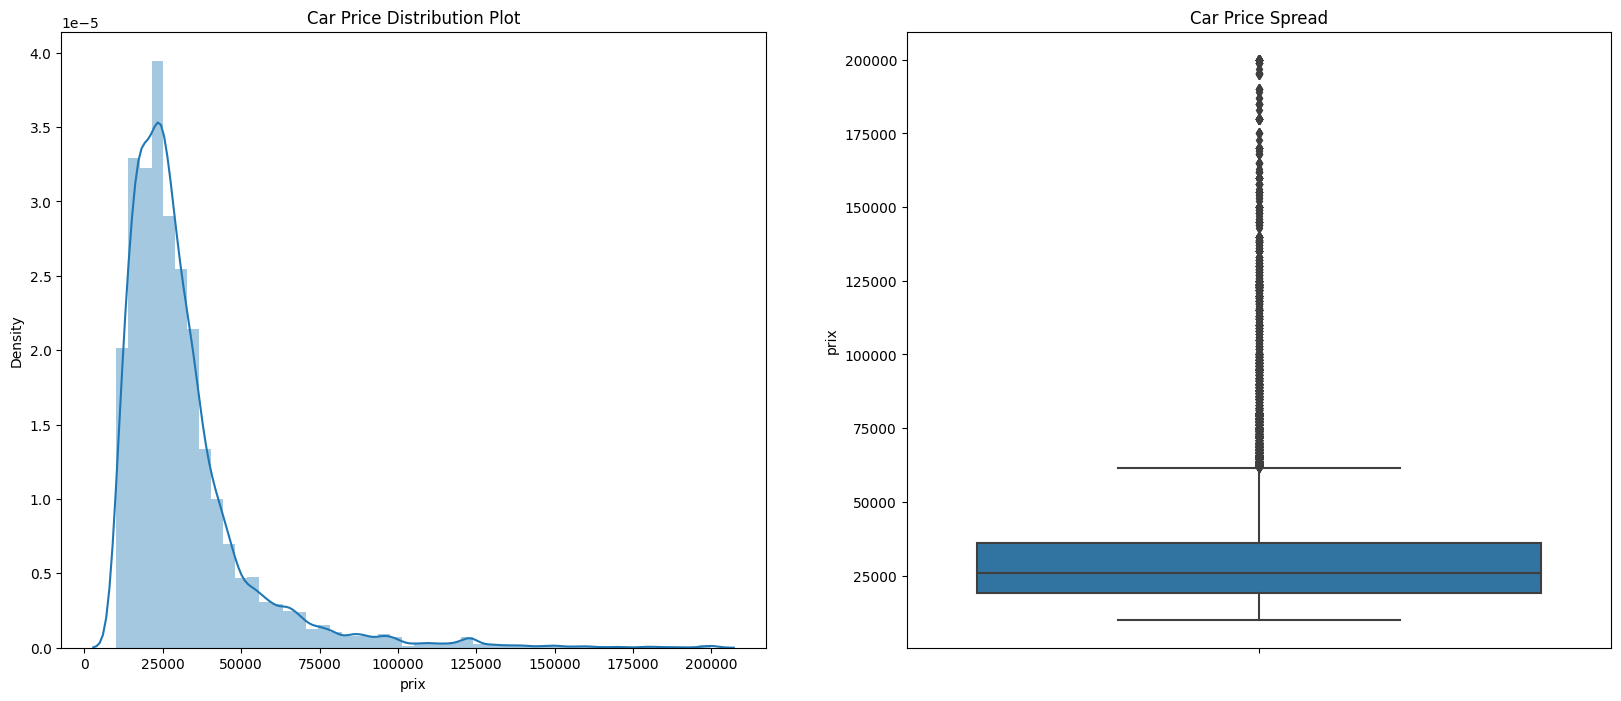

In [22]:
data['prix']=data['prix'].apply(float)
data['prix']=data['prix'].apply(int)

plt.figure(figsize=(20,8))

plt.subplot(1,2,1)
plt.title('Car Price Distribution Plot')
sns.distplot(data.prix)                                                               

plt.subplot(1,2,2)
plt.title('Car Price Spread')
sns.boxplot(y=data.prix) 
                                                       
plt.show() 

The interquartile range is the best measure of variability for skewed distributions or data sets with outliers. Because it's based on values that come from the middle half of the distribution, it's unlikely to be influenced by outliers.


In [23]:
data.shape

(44660, 7)

In [24]:
data

,kilometrage,age,marque,modele,carburant,boite,prix
0,145000.0,5,volkswagen,golf 7,Essence,Manuelle,58500
1,110000.0,4,toyota,yaris,Essence,Manuelle,35000
2,190000.0,8,isuzu,d-max,Diesel,Manuelle,57000
3,164000.0,13,citroen,c4,Essence,Manuelle,23500
4,80000.0,8,nissan,juke,Essence,Manuelle,46000
...,...,...,...,...,...,...,...
52414,300000.0,24,opel,corsa,Essence,Manuelle,12000
52415,155000.0,11,mini,cooper,Essence,Manuelle,33000
52416,68000.0,4,skoda,fabia,Essence,Manuelle,34800
52418,161000.0,11,bmw,serie 3,Essence,Automatique,44900


In [25]:
data['prix']=data['prix'].apply(float)
data['prix']=data['prix'].apply(int)
grouped_df = data.groupby('modele')['prix']
median = grouped_df.median()
q1 = grouped_df.quantile(0.25)
q3 = grouped_df.quantile(0.75)
iqr = q3 - q1

lower_bound = median - 1.5 * iqr
upper_bound = median + 1.5 * iqr

# reset the index of lower_bound and upper_bound
lower_bound = lower_bound.reset_index()
upper_bound = upper_bound.reset_index()

# merge the bounds with the original data
merged_data = pd.merge(data, lower_bound, on='modele', suffixes=('', '_lower'))
merged_data = pd.merge(merged_data, upper_bound, on='modele', suffixes=('', '_upper'))

# create a Boolean mask for the outliers
outliers_mask = (merged_data['prix'] >= merged_data['prix_lower']) & (merged_data['prix'] <= merged_data['prix_upper'])

# filter the data to remove the outliers
data = merged_data[outliers_mask]
data.drop(['prix_upper', 'prix_lower'], axis=1, inplace=True)   
data

,kilometrage,age,marque,modele,carburant,boite,prix
0,145000.0,5,volkswagen,golf 7,Essence,Manuelle,58500
1,115000.0,4,volkswagen,golf 7,Essence,Manuelle,52000
2,78000.0,7,volkswagen,golf 7,Essence,Manuelle,49000
3,125000.0,7,volkswagen,golf 7,Essence,Manuelle,55000
4,110000.0,6,volkswagen,golf 7,Essence,Manuelle,56000
...,...,...,...,...,...,...,...
44655,27800.0,2,mahindra,hover,Essence,Manuelle,31000
44656,127000.0,4,mahindra,hover,Essence,Manuelle,26500
44657,60000.0,3,mahindra,hover,Essence,Manuelle,35000
44658,46000.0,4,mahindra,hover,Essence,Manuelle,32500


In [26]:
data.describe() 

,kilometrage,age,prix
count,41271.000000,41271.000000,41271.000000
mean,175313.099150,10.359114,28929.633762
std,76773.097668,5.496155,15439.712570
min,5000.000000,0.000000,10000.000000
25%,120000.000000,6.000000,18500.000000
50%,170000.000000,10.000000,25000.000000
75%,220000.000000,14.000000,34000.000000
max,400000.000000,29.000000,146000.000000


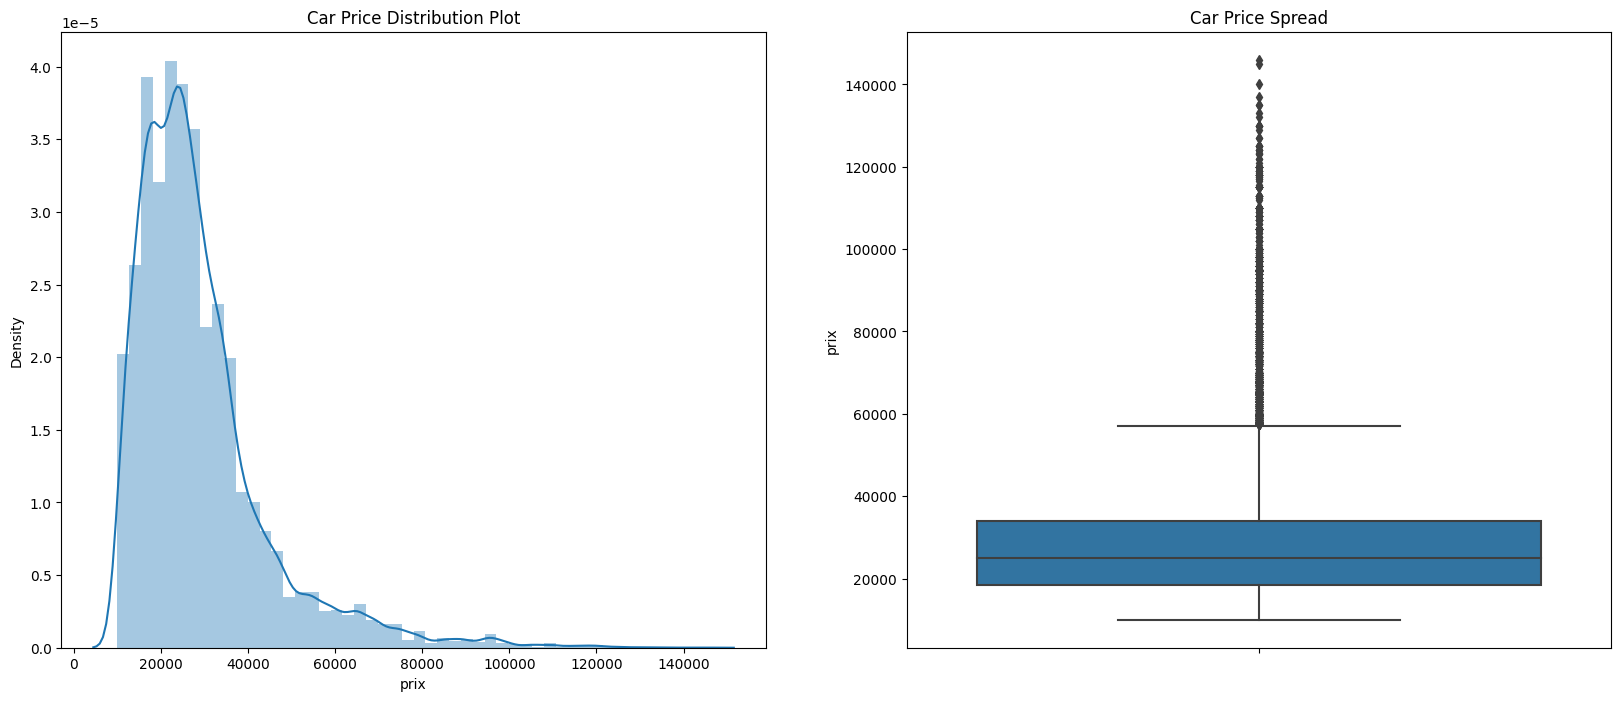

In [27]:

plt.figure(figsize=(20,8))

plt.subplot(1,2,1)
plt.title('Car Price Distribution Plot')
sns.distplot(data.prix)                                                               

plt.subplot(1,2,2)
plt.title('Car Price Spread')
sns.boxplot(y=data.prix) 
                                                       
plt.show() 

<Axes: ylabel='Frequency'>

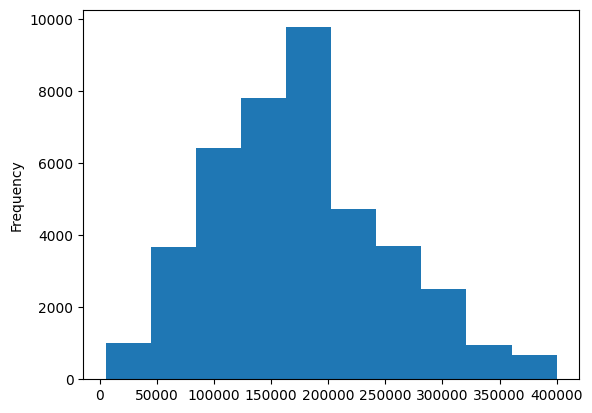

In [28]:
data['kilometrage'].plot(kind='hist') 

<Axes: ylabel='Frequency'>

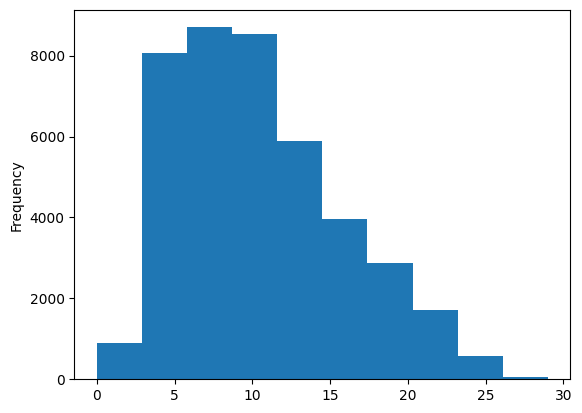

In [29]:
data['age'].plot(kind='hist') 

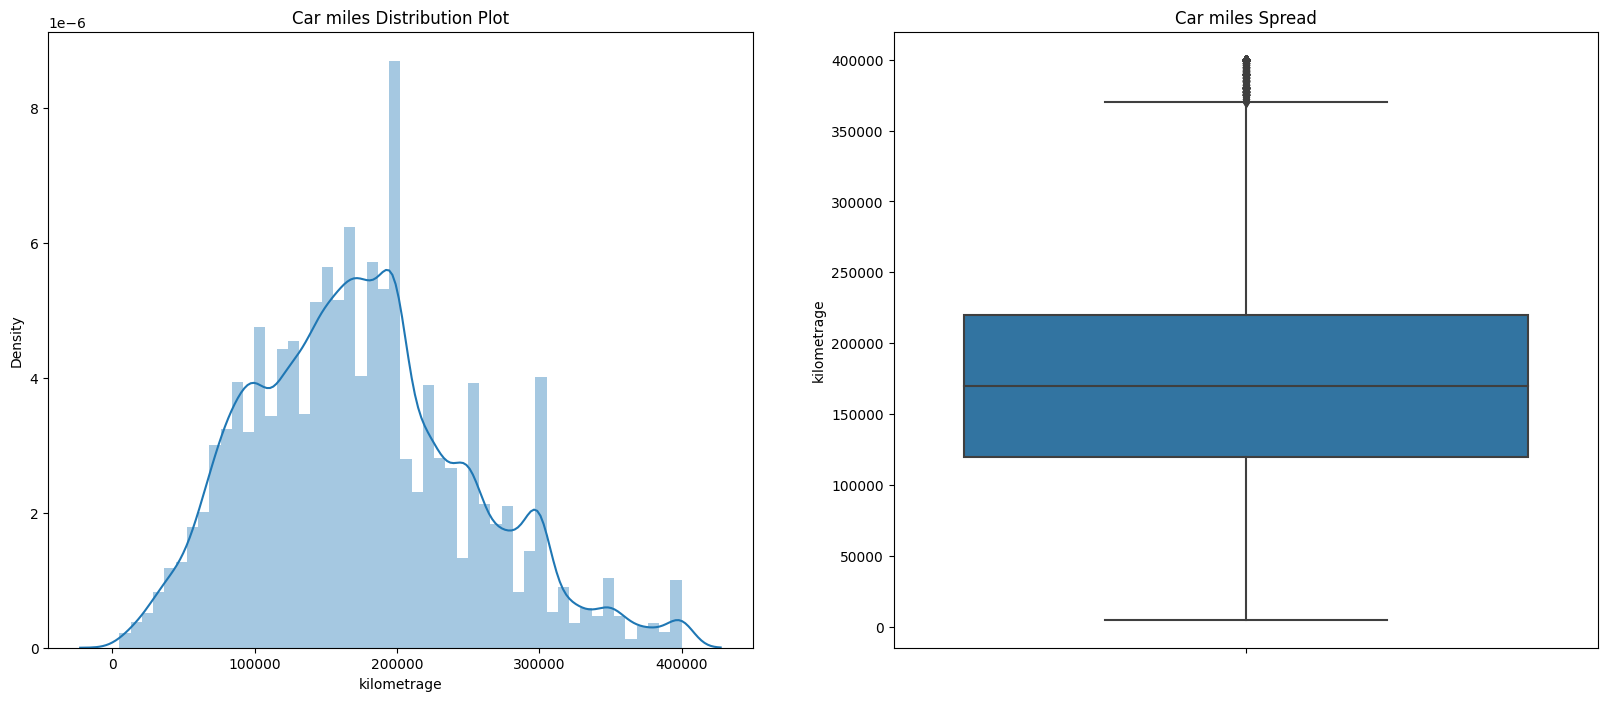

In [30]:

plt.figure(figsize=(20,8))

plt.subplot(1,2,1)
plt.title('Car miles Distribution Plot')
sns.distplot(data.kilometrage)                                                               

plt.subplot(1,2,2)
plt.title('Car miles Spread')
sns.boxplot(y=data.kilometrage) 
                                                       
plt.show() 

In [31]:
old_skew = data.skew().sort_values(ascending=False)
old_skew #price is skewed to the right 

prix           2.058766
age            0.636952
kilometrage    0.449809
dtype: float64

# data leck

In [32]:
new_df = data.copy()
new_df = pd.get_dummies(new_df, columns = ['carburant', 'boite', 'marque', 'modele'])


In [33]:
columns = new_df.columns
columns

Index(['kilometrage', 'age', 'prix', 'carburant_Diesel',
       'carburant_Electrique', 'carburant_Essence', 'carburant_Hybride',
       'boite_Automatique', 'boite_Manuelle', 'marque_audi',
       ...
       'modele_sandero', 'modele_scenic', 'modele_serie 1', 'modele_serie 3',
       'modele_serie 5', 'modele_siena', 'modele_sportage', 'modele_swift',
       'modele_symbol', 'modele_yaris'],
      dtype='object', length=135)

In [34]:
new_df.to_numpy()

array([[1.45e+05, 5.00e+00, 5.85e+04, ..., 0.00e+00, 0.00e+00, 0.00e+00],
       [1.15e+05, 4.00e+00, 5.20e+04, ..., 0.00e+00, 0.00e+00, 0.00e+00],
       [7.80e+04, 7.00e+00, 4.90e+04, ..., 0.00e+00, 0.00e+00, 0.00e+00],
       ...,
       [6.00e+04, 3.00e+00, 3.50e+04, ..., 0.00e+00, 0.00e+00, 0.00e+00],
       [4.60e+04, 4.00e+00, 3.25e+04, ..., 0.00e+00, 0.00e+00, 0.00e+00],
       [1.27e+05, 4.00e+00, 2.65e+04, ..., 0.00e+00, 0.00e+00, 0.00e+00]])

In [35]:
new_df = np.array(new_df)
sorted_indexes = np.argsort(new_df[:,2])
sorted_samples = new_df[sorted_indexes]
split = 0.20
real_index = 0
index = 0 
test_set = []
while real_index < sorted_samples.shape[0]:
  index = int(np.round(real_index))
  test_set.append(sorted_samples[index])
  real_index += 1/split
train_set = list(new_df)
train_set = [list(x) for x in new_df]
for sample in test_set:
  train_set.remove(list(sample))


In [36]:
train_set = pd.DataFrame(train_set, columns = columns)

In [37]:
test_set = pd.DataFrame(test_set, columns = columns)

In [38]:
train_set.shape , test_set.shape

((33016, 135), (8255, 135))

In [39]:
x_train = train_set.drop('prix', axis = 1)
x_test = test_set.drop('prix', axis = 1)

y_test = test_set[['prix']]
y_train = train_set[['prix']]

In [40]:
print("x_train - >  ",x_train.shape)
print("x_test - >  ",x_test.shape)
print("y_train - >  ",y_train.shape)
print("y_test - >  ",y_test.shape)


x_train - >   (33016, 134)
x_test - >   (8255, 134)
y_train - >   (33016, 1)
y_test - >   (8255, 1)


In [41]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()


y_train_scaled = scaler.fit_transform(y_train)
y_test_scaled = scaler.transform(y_test)

y_train_scaled = y_train_scaled.flatten()
y_test_scaled = y_test_scaled.flatten()

#turn to df
y_train = pd.DataFrame(y_train_scaled, columns=['prix'])
y_test = pd.DataFrame(y_test_scaled, columns=['prix']) 

In [42]:
x_train.columns

Index(['kilometrage', 'age', 'carburant_Diesel', 'carburant_Electrique',
       'carburant_Essence', 'carburant_Hybride', 'boite_Automatique',
       'boite_Manuelle', 'marque_audi', 'marque_autres',
       ...
       'modele_sandero', 'modele_scenic', 'modele_serie 1', 'modele_serie 3',
       'modele_serie 5', 'modele_siena', 'modele_sportage', 'modele_swift',
       'modele_symbol', 'modele_yaris'],
      dtype='object', length=134)

In [43]:
features_to_scale = ['age', 'kilometrage']

scaler = RobustScaler()

x_train[features_to_scale] = scaler.fit_transform(x_train[features_to_scale])

x_test[features_to_scale] = scaler.transform(x_test[features_to_scale])

In [44]:
import xgboost 
xgb = xgboost.XGBRegressor(n_estimators=1000, random_state=42, learning_rate=0.1)
xgb.fit(x_train, y_train) 



XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [45]:
predictions = xgb.predict(x_test)


errors = abs(predictions - y_test['prix'].values)
print('Mean Absolute Error:', (np.mean(errors)), 'TND.')
print("R^2 : ", r2_score(y_test, predictions))
print("RMSE:",np.sqrt(mean_squared_error(y_test, predictions)))

Mean Absolute Error: 0.19134499104145475 TND.
R^2 :  0.8985127263581492
RMSE: 0.31779130420334656


In [46]:
x_test.shape, y_test.shape

((8255, 134), (8255, 1))

In [47]:
m = keras.metrics.RootMeanSquaredError()
# model architecture 
model = Sequential()
model.add(Dense(128, input_shape=(134,), activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='linear'))

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10)
early_stopping = EarlyStopping(monitor='val_loss', patience=20)
model.compile(loss='mean_squared_error', optimizer='adam', metrics=m ) 

history = model.fit(x_train, y_train, epochs=200, batch_size=128, validation_data= (x_test, y_test),shuffle=True,
          callbacks=[lr_scheduler, early_stopping])


Epoch 1/200
258/258 [==============================] - 4s 14ms/step - loss: 0.2119 - root_mean_squared_error: 0.4604 - val_loss: 0.1245 - val_root_mean_squared_error: 0.3528 - lr: 0.0010
Epoch 2/200
258/258 [==============================] - 1s 3ms/step - loss: 0.1169 - root_mean_squared_error: 0.3418 - val_loss: 0.1197 - val_root_mean_squared_error: 0.3460 - lr: 0.0010
Epoch 3/200
258/258 [==============================] - 1s 3ms/step - loss: 0.1124 - root_mean_squared_error: 0.3352 - val_loss: 0.1185 - val_root_mean_squared_error: 0.3442 - lr: 0.0010
Epoch 4/200
258/258 [==============================] - 1s 3ms/step - loss: 0.1088 - root_mean_squared_error: 0.3298 - val_loss: 0.1160 - val_root_mean_squared_error: 0.3405 - lr: 0.0010
Epoch 5/200
258/258 [==============================] - 1s 4ms/step - loss: 0.1079 - root_mean_squared_error: 0.3285 - val_loss: 0.1129 - val_root_mean_squared_error: 0.3359 - lr: 0.0010
Epoch 6/200
258/258 [==============================] - 1s 4ms/step - 

In [48]:
predictions = model.predict(x_test)
r2 = r2_score(y_test, predictions) 

print('Test R2 score:', r2)  #64 neuro
print("MAE :", mean_absolute_error(y_test,predictions))
print("RMSE:",np.sqrt(mean_squared_error(y_test, predictions)))

258/258 [==============================] - 0s 991us/step
Test R2 score: 0.8937147660632806
MAE : 0.19716393651575992
RMSE: 0.3252165833007412


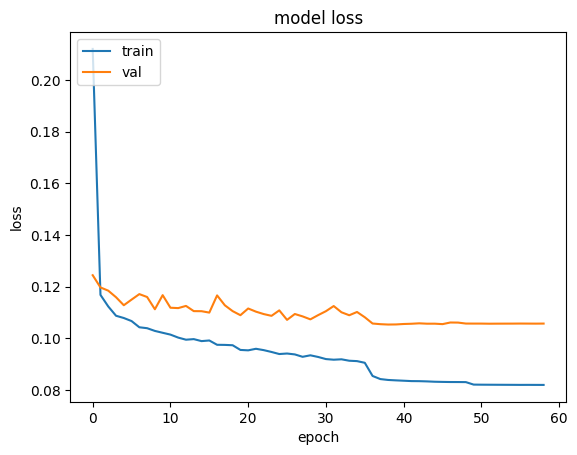

In [49]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch') 
plt.legend(['train', 'val'], loc='upper left')
plt.show()

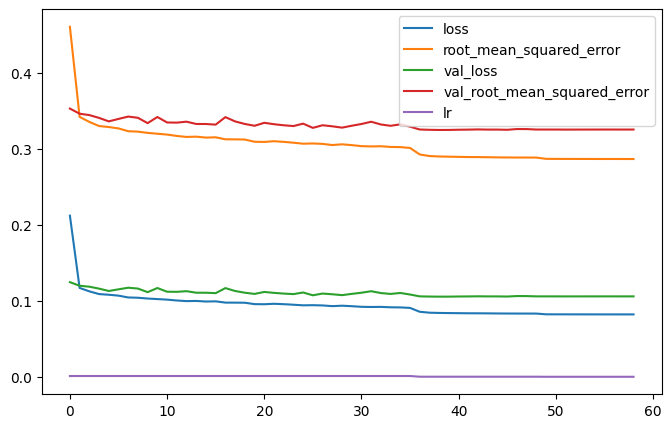

In [50]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

In [52]:
import pickle
pickle.dump(model, open("seq.pkl", "wb"))